<a href="https://colab.research.google.com/github/DeniseValeriaVelarde/Calibra-o_camera/blob/main/Calibra%C3%A7%C3%A3o_camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Foram tiradas 18 fotos de uma imagem quadriculada xadrez preta e branco de 2.9 cm de largura, foi utilizada a camera do notebook mesmo pois não tinha webcam e a principio parecia menos complicado.

In [ ]:
#importa as bibliotecas
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
#acesso ao drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#meu tabuleiro tem 7 quadrados por 10 quadrados
chessboard_size = (9, 6) # Número de cantos internos
square_size = 29 # Tamanho em milímetros

In [ ]:
#aqui ele pega todas as fotos jpg da pasta Imagens_calibra
images_folder_path = "/content/drive/MyDrive/Imagens_calibra/*.jpg"


In [ ]:
!ls "/content/drive/MyDrive/Imagens_calibra/"

WIN_20250929_19_08_53_Pro.jpg  WIN_20250929_19_24_53_Pro.jpg
WIN_20250929_19_14_11_Pro.jpg  WIN_20250929_19_26_01_Pro.jpg
WIN_20250929_19_14_21_Pro.jpg  WIN_20250929_19_26_17_Pro.jpg
WIN_20250929_19_18_05_Pro.jpg  WIN_20250929_19_27_03_Pro.jpg
WIN_20250929_19_19_18_Pro.jpg  WIN_20250929_19_27_29_Pro.jpg
WIN_20250929_19_19_33_Pro.jpg  WIN_20250929_19_28_01_Pro.jpg
WIN_20250929_19_21_15_Pro.jpg  WIN_20250929_19_28_23_Pro.jpg
WIN_20250929_19_21_41_Pro.jpg  WIN_20250929_19_28_43_Pro.jpg
WIN_20250929_19_22_56_Pro.jpg  WIN_20250929_19_28_50_Pro.jpg


In [ ]:
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp = objp * square_size # Escala para tamanho real

Primeiramente ele localiza e percorre todas as imagens de um diretório específico.
Para cada imagem, ele a converte para tons de cinza e tenta localizar os cantos internos do padrão de xadrez. Se os cantos são encontrados,
o código refina suas posições para obter precisão de subpixel e armazena os pontos 2D da imagem junto com os pontos 3D ideais correspondentes do objeto.
Após analisar todas as imagens válidas, ele utiliza os pares de pontos 2D e 3D coletados para chamar a função `cv2.calibrateCamera`, que calcula
a matriz da câmera (mtx) e os coeficientes de distorção (dist). Por fim, ele mede a precisão do resultado calculando o erro de reprojeção e salva
os parâmetros de calibração em um arquivo .npz para serem usados posteriormente na correção de novas imagens.

In [ ]:
#armazena os pontos do objeto e os pontos da imagem
objpoints = []
imgpoints = []

image_paths = glob.glob(images_folder_path)
if not image_paths:
    print(f"ERRO CRÍTICO: Nenhuma imagem encontrada no caminho '{images_folder_path}'")
else:
    print(f"Encontradas {len(image_paths)} imagens")

    for image_path in image_paths:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        if ret == True:
            print(f"Cantos encontrados em: {os.path.basename(image_path)}")
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
            imgpoints.append(corners2)
        else:
            print(f"Cantos NÃO encontrados em: {os.path.basename(image_path)}")

    if objpoints:
        print("\nIniciando a calibração da câmera...")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

        print("\n--- RESULTADOS DA CALIBRAÇÃO ---")
        print("Matriz da Câmera (mtx):\n", mtx)
        print("\nCoeficientes de Distorção (dist):\n", dist)

        mean_error = 0
        for i in range(len(objpoints)):
            imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
            mean_error += error

        total_reprojection_error = mean_error / len(objpoints)
        print(f"\nErro Total de Reprojeção: {total_reprojection_error}")
        #salva os parametros de calibração, pra testar depois
        save_path = "/content/drive/My Drive/camera_calibration_data.npz"
        np.savez(save_path, mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
        print(f"\nParâmetros salvos em: {save_path}")
    else:
        print("\nNenhum canto foi detectado em nenhuma das imagens processadas")


Encontradas 19 imagens
Cantos encontrados em: WIN_20250929_19_26_17_Pro.jpg
Cantos encontrados em: WIN_20250929_19_28_50_Pro.jpg
Cantos encontrados em: WIN_20250929_19_27_03_Pro.jpg
Cantos encontrados em: WIN_20250929_19_18_05_Pro.jpg
Cantos encontrados em: WIN_20250929_19_14_21_Pro.jpg
Cantos encontrados em: WIN_20250929_19_21_15_Pro.jpg
Cantos encontrados em: WIN_20250929_19_28_01_Pro.jpg
Cantos encontrados em: WIN_20250929_19_19_33_Pro.jpg
Cantos encontrados em: WIN_20250929_19_19_18_Pro.jpg
Cantos encontrados em: WIN_20250929_19_26_01_Pro.jpg
Cantos encontrados em: WIN_20250929_19_24_53_Pro.jpg
Cantos encontrados em: WIN_20250929_19_22_56_Pro.jpg
Cantos encontrados em: WIN_20250929_19_28_43_Pro.jpg
Cantos encontrados em: WIN_20250929_19_28_23_Pro.jpg
Cantos encontrados em: WIN_20250929_19_14_11_Pro.jpg
Cantos encontrados em: WIN_20250929_19_08_53_Pro.jpg
Cantos encontrados em: WIN_20250929_19_21_41_Pro.jpg
Cantos encontrados em: WIN_20250929_19_27_29_Pro.jpg
Cantos NÃO encontrados 

Aplicando correção de distorção...


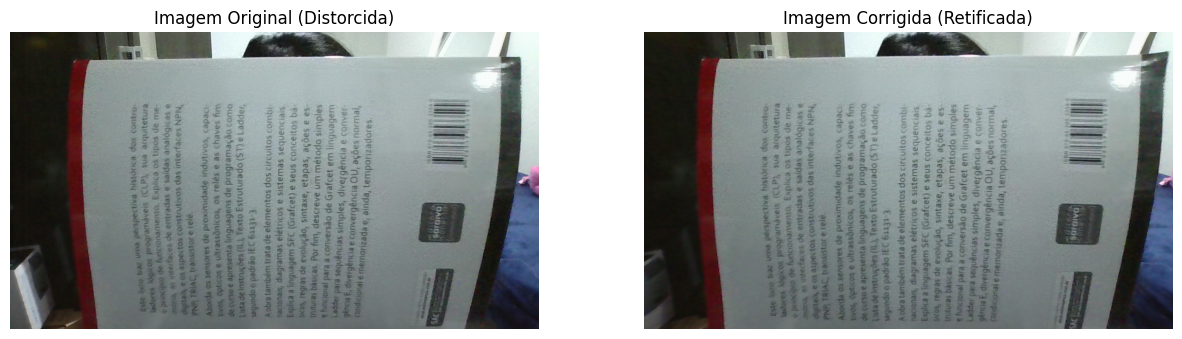

In [ ]:
# Caminho para os parâmetros de calibração salvo
calibration_data_path = "/content/drive/MyDrive/camera_calibration_data.npz"

# Caminho para imagem de teste
test_image_path = "/content/drive/MyDrive/Imagens_calibra/minha_foto_teste.jpg"

# Carregar os parâmetros de calibração
try:
    with np.load(calibration_data_path) as data:
        mtx = data['mtx']
        dist = data['dist']
except FileNotFoundError:
    print(f"ERRO: Arquivo de calibração não encontrado em: {calibration_data_path}")
    # Encerra a execução se o arquivo não for encontrado
    raise

# Carregar a imagem de teste
img = cv2.imread(test_image_path)
if img is None:
    print(f"ERRO: Não foi possível carregar a imagem de teste em: {test_image_path}")
    # Encerra a execução se a imagem não for encontrada
    raise

print("Aplicando correção de distorção...")

h, w = img.shape[:2]
#nova matriz da câmera otimizada
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))

# Corrige a distorção
undistorted_img = cv2.undistort(img, mtx, dist, None, newcameramtx)
x, y, w, h = roi
undistorted_img = undistorted_img[y:y+h, x:x+w]

# Exibir as imagens lado a lado para comparação
# converte de BGR (OpenCV) para RGB (Matplotlib) para as cores ficarem corretas
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted_img_rgb = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Imagem Original (Distorcida)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(undistorted_img_rgb)
plt.title('Imagem Corrigida (Retificada)')
plt.axis('off')

plt.show()